In [42]:
import scipy
import pandas as pd
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import networkx as nx
from fastconsensus.core import construct_sparse_consensus_matrix,threshold_matrix,triadic_closure,check_convergence,get_algorithm
import igraph as ig

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [43]:
%%R

suppressPackageStartupMessages({
    library(cowplot)
    library(ggsegGlasser)
    library(ggseg)
    library(LaCroixColoR)
    library(patchwork)
    library(tidyverse)
    theme_set(theme_cowplot())
})

options(dplyr.width = Inf)

# Load Louvain clustering results
### Code already run separately in Peripheral/louvain_parameter_sweep.py

In [59]:
data_path = "/Users/abry4213/data/OCDA/"

# Load brain region labels
brain_regions = pd.read_csv("../data/brain_area_labels.csv", header=None, names=['node', 'Glasser_RH_ROI']).drop('node', axis=1)
brain_regions['node_index'] = range(1, brain_regions.shape[0]+1)

# Filter to node_index<=180 and drop node_index 92
brain_regions = brain_regions[brain_regions['node_index']<=180]
brain_regions = brain_regions[brain_regions['node_index']!=92]

louvain_gamma_range = np.arange(0.5, 1.51, 0.05)
louvain_sweep_res_list = []
for gamma_val in louvain_gamma_range:
    # Use string formatting to two decimal places
    gamma_val_str = "{:.2f}".format(gamma_val)
    louvain_modules = (pd.read_csv(f"{data_path}/Louvain_results/Louvain_Rubinov_assignments_100reps_gamma{gamma_val_str}.csv", header=None))

    # Sweep across each column and find the number of unique values
    num_modules_this_gamma = louvain_modules.apply(lambda x: len(x.unique()), axis=0)

    mean_num_modules = num_modules_this_gamma.mean()
    std_num_modules = num_modules_this_gamma.std()
    this_gamma_df = pd.DataFrame({'gamma_val': gamma_val, 'mean_num_modules': mean_num_modules, 'sd_num_modules': std_num_modules}, index=[0])
    louvain_sweep_res_list.append(this_gamma_df)

louvain_sweep_res_df = pd.concat(louvain_sweep_res_list, axis=0)

In [55]:
%%R -i louvain_sweep_res_df

louvain_sweep_res_df %>%
    ggplot(data=., mapping=aes(x=gamma_val, y=mean_num_modules)) +
    geom_line() +
    geom_ribbon(aes(ymin=mean_num_modules-sd_num_modules, ymax=mean_num_modules+sd_num_modules), alpha=0.3) +
    geom_vline(xintercept=1, color="red") +
    scale_x_continuous(expand=c(0,0)) +
    ylab("# Communities") +
    xlab("Gamma resolution parameter") +
    ggtitle("Number of communities detected by Louvain\nwith 100 seeds, 100 iterations per seed") +
    theme(plot.title = element_text(hjust=0.5))
ggsave("../plots/Louvain_num_communities_by_gamma.svg", width=5, height=4, dpi=300, units="in")

/Users/abry4213/miniforge3/envs/annie_env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


### Seed--seed ENMI at gamma=1

In [54]:
target_gamma = '1.00'

NMI_results_sweep_across_seeds = (pd.read_csv(f"{data_path}/Louvain_results/NMI_results_sweep_across_seeds_{target_gamma}.csv", 
                                                     header=None, 
                                                     names=['target_seed', 'comparison_seed', 'NMI'])
)

mean_NMI_by_seed = NMI_results_sweep_across_seeds.query("comparison_seed != target_seed").groupby('comparison_seed')['NMI'].mean().reset_index()

In [57]:
%%R -i NMI_results_sweep_across_seeds,mean_NMI_by_seed

seed_order <- mean_NMI_by_seed %>% arrange(desc(NMI)) %>% pull(comparison_seed)

heatmap_min <- min(NMI_results_sweep_across_seeds$NMI)
heatmap_max <- max(NMI_results_sweep_across_seeds$NMI)

heatmap_plot <- NMI_results_sweep_across_seeds %>% 
    mutate(target_seed = factor(target_seed, levels=seed_order),
           comparison_seed = factor(comparison_seed, levels=seed_order)) %>%
    ggplot(data=., mapping=aes(x=target_seed, y=comparison_seed, fill=NMI)) +
    geom_tile() +
    scale_fill_distiller(palette="Spectral") +
    # Reverse the order of the y-axis, which is a factor
    scale_y_discrete(limits=rev(seed_order)) +
    ylab("Seed 2") +
    xlab("Seed 1") +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank())

bar_plot <- mean_NMI_by_seed %>%
    mutate(comparison_seed = factor(comparison_seed, levels=seed_order)) %>%
    ggplot(data=., mapping=aes(x=0, y=comparison_seed, fill=NMI)) +
    geom_tile(color='black') +
    scale_fill_distiller(palette="Spectral", limits=c(heatmap_min, heatmap_max)) +
    # Reverse the order of the y-axis, which is a factor
    scale_y_discrete(limits=rev(seed_order)) +
    ylab("Seed 2") +
    xlab("Seed 1") +
    theme(axis.text = element_blank(),
          axis.ticks = element_blank())

wrap_plots(list(heatmap_plot, bar_plot), ncol=2, widths=c(0.95, 0.05)) + 
    plot_layout(guides = "collect",axis_titles = "collect_y") & 
    theme(legend.position = 'bottom')
ggsave("../plots/Louvain_gamma1_NMI.svg", width=6, height=5, dpi=300, units="in")

In addition: Warning messages:
1: In scale_y_discrete(limits = rev(seed_order)) :
  Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?
2: In scale_y_discrete(limits = rev(seed_order)) :
  Continuous limits supplied to discrete scale.
ℹ Did you mean `limits = factor(...)` or `scale_*_continuous()`?


## Final solution: seed 98 with gamma=1.00

In [60]:
final_louvain_res = ((pd.read_csv(f"{data_path}/Louvain_results/Louvain_Rubinov_assignments_100reps_gamma1.00.csv", 
                                 names=np.arange(1, 101)))[[98]]
                                 .rename(columns={98: 'Louvain_community'})
                                 .assign(node_index=brain_regions.node_index.values)
                                 .merge(brain_regions, on='node_index')
)

# Save to csv
final_louvain_res.to_csv("../data/louvain_community_assignments_BCT_gamma1.csv", index=False)

Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'region', 'side', 'geometry'


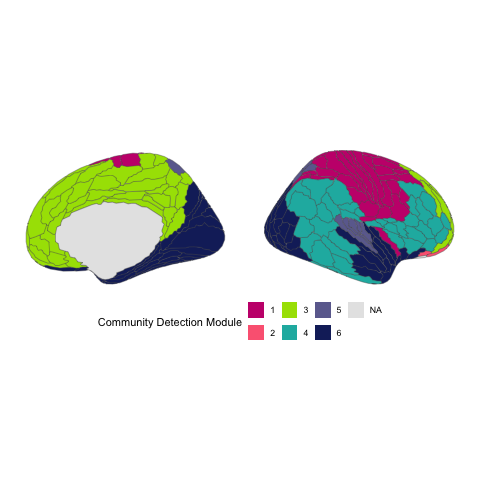

In [65]:
%%R -i final_louvain_res

# Load Glasser parcellation data
glasser_lookup_table <- glasser %>% as_tibble()

gg_color_hue <- function(n) {
    hues = seq(15, 375, length = n + 1)
    hcl(h = hues, l = 65, c = 100)[1:n]
}

# Tidy data
final_louvain_res <- final_louvain_res %>% 
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "R_", "rh_R_")) %>%
  mutate(Glasser_RH_ROI = str_replace_all(Glasser_RH_ROI, "_ROI", ""))%>% 
  dplyr::rename("label" = "Glasser_RH_ROI")

# Merge modules + Glasser data
modules_in_glasser_atlas <- final_louvain_res %>% 
  left_join(., glasser_lookup_table) %>%
  arrange(Louvain_community)

# Plot modules on cortical surface with Glasser parcellation
modules_in_glasser_atlas %>%
  mutate(Louvain_community = as.factor(Louvain_community)) %>%
  ggplot() +
  geom_brain(atlas=glasser, mapping=aes(fill=Louvain_community),
             hemi = "right") +
  theme_void()  + 
  scale_fill_manual(values=lacroix_palette("PassionFruit", 6), na.value="gray90") +
  labs(fill = "Community Detection Module") +
  theme(legend.position="bottom")
# ggsave("../plots/Louvain_gamma1_in_brain.svg", width=6, height=5, dpi=300, units="in")